# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import csv
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import random
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten

# TODO: Fill this in based on where you saved the training and testing data
training_file = '../traffic-signs-data/train.p'
validation_file = '../traffic-signs-data/valid.p'
testing_file = '../traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']

# Concatenate train and validation to be the bigger training set
# Use StratifiedShuffleSplit to split train and valid for cross-validation
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)
n_valid = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_test))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [3]:
# In order to use the full training set, merge training and validation set here and use cross validation
X_train = np.concatenate((X_train, X_valid), axis=0)
n_train = len(X_train)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)

Number of training examples = 39209
Number of testing examples = 12630


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

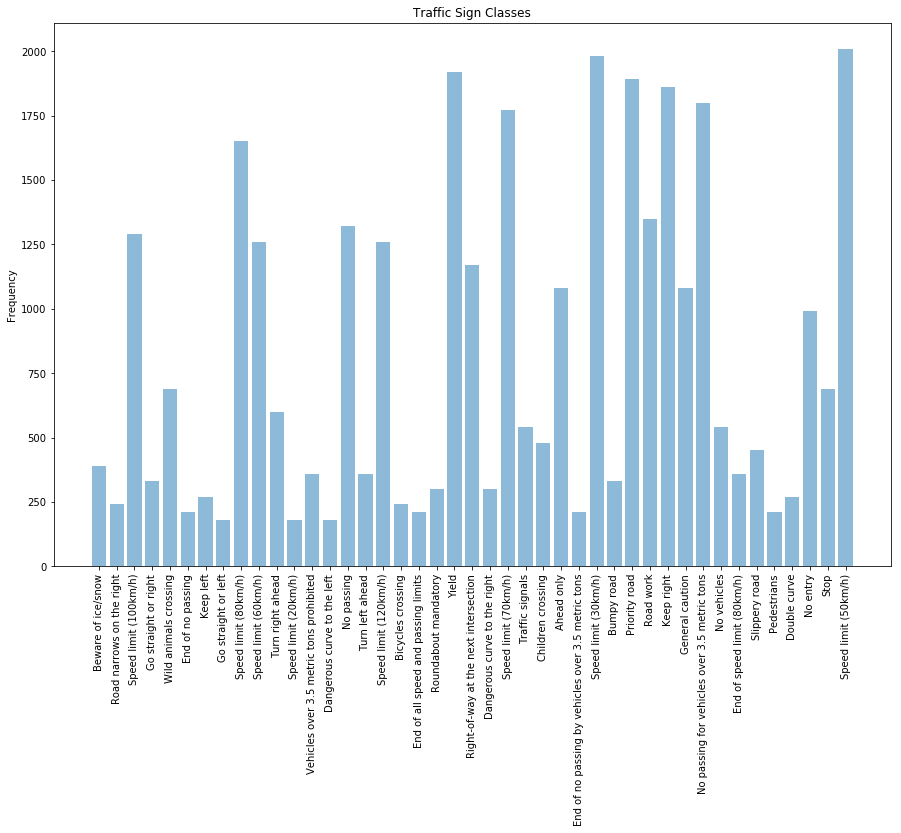

In [4]:
### Read the csv file to get labels
# Visualizations will be shown in the notebook.
%matplotlib inline

with open('signnames.csv', 'r') as signfile:
    signs = csv.reader(signfile)
    sign_dict = {}
    for row in signs:
        try:
            int(row[0])
            sign_dict[row[0]] = row[1]
        except:
            continue

# print(sign_dict)

def get_frequencies(num_labels, sign_dict):
    text_labels = [sign_dict[str(num_label)] for num_label in num_labels]
    # Get frequencies for text_labels
    freq_dict = {}
    for text_label in text_labels:
        if text_label not in freq_dict:
            freq_dict[text_label] = 1
        else:
            freq_dict[text_label] += 1
    return freq_dict

sign_frequencies = get_frequencies(y_train, sign_dict)

fig, ax = plt.subplots(figsize=(15, 10))
classes = list(sign_dict.values())
ind = np.arange(len(classes))
width = 0.8

rects = ax.bar(ind, sign_frequencies.values(), width, align="edge", alpha=0.5)
ax.set_ylabel('Frequency')
ax.set_title('Traffic Sign Classes')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(sign_frequencies.keys(), rotation=90)
plt.show()

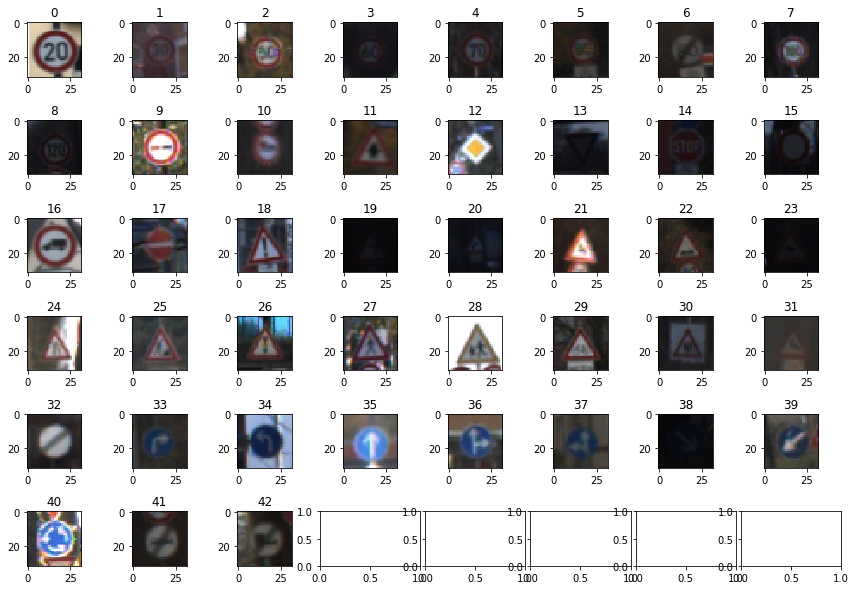

In [5]:
def get_class_image(X_train, y_train, class_label):
    for i in range(len(y_train)):
        if y_train[i] == class_label:
            return X_train[i]
    return False

def show_class_images():
    fig, axes = plt.subplots(6, 8, figsize=(15, 10))
    fig.subplots_adjust(hspace = .8, wspace=.05)
    axes = axes.ravel()

    for i in range(43):
        class_image = get_class_image(X_train, y_train, i)
        axes[i].imshow(class_image, cmap="gray")
        axes[i].set_title(str(i))

show_class_images()

From the above figure we can see that the distribution of the classes are far from uniform. This will affect the performance of the model, so one key step to preprocess the training data is to augment the dataset by filling in training examples for the under-represented classes. The approach I adopt here is to translate, rotate, zoom in or out on the images using `opencv`. I will augment the classes to 1200 examples if it has less than that.

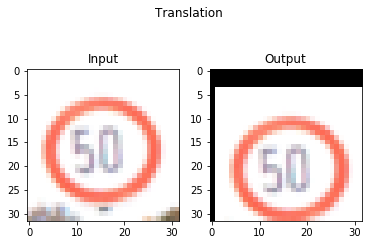

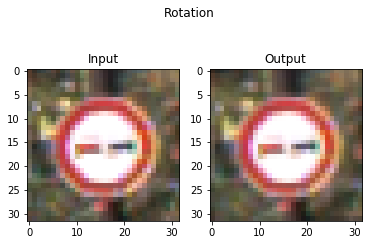

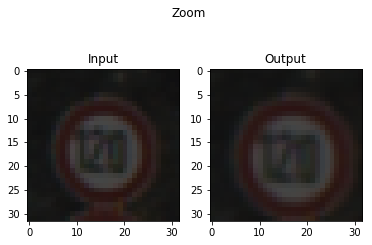

In [6]:
NUM_IN_CLASS = 800

def random_translate(img):
    rows,cols,ch = img.shape
    x = random.randint(-4, 4)
    y = random.randint(-4, 4)
    M = np.float32([[1,0,x],[0,1,y]])
    return cv.warpAffine(img,M,(cols,rows))

def random_rotate(img):
    rows,cols,ch = img.shape
    degree = random.randint(-8, 8)
    M = cv.getRotationMatrix2D((cols/2,rows/2),degree,1)
    return cv.warpAffine(img,M,(cols,rows))

def random_zoom(img):
    x = random.randint(1, 5)
    y = random.randint(26, 31)
    pts1 = np.float32([[x,x],[y,x],[x,y],[y,y]])
    pts2 = np.float32([[0,0],[31,0],[0,31],[31,31]])
    M = cv.getPerspectiveTransform(pts1,pts2)
    return cv.warpPerspective(img,M,(32,32))

def random_transform_img(rand_img, transform_type_n=None):
    """
    transform_type_n:
        0: random_translate
        1: random_rotate
        2: random_zoom
    """
    transform_funcs = [random_translate, random_rotate, random_zoom]
    if transform_type_n:
        transform = transform_funcs[transform_type_n]
        return transform(rand_img)
    transform = random.choice(transform_funcs)
    return transform(rand_img)
    
def split_by_class(X_train, y_train):
    """
    Return data_by_classes, list of tuples, each tuple: (X_train_class_i, y_train_class_i)
    Note: X_train_class_i is a list, y_train_class_i is a number
    """
    # class_dict {y_label: [x_train_for_this_label]}
    class_dict = {}
    for i in range(len(y_train)):
        if y_train[i] not in class_dict:
            class_dict[y_train[i]] = [X_train[i]]
        else:
            class_dict[y_train[i]].append(X_train[i])
    data_by_classes = [(X_train_class_i, y_train_class_i) for y_train_class_i, X_train_class_i in class_dict.items()]
    return data_by_classes

def augment_by_class(training_data_tuple):
    """
    Augment the data by translating, rotating, zooming, until it has 1200 examples
    training_data_tuple: (X_train_class_i, y_train_class_i), 
    X_train_class_i is a list, y_train_class_i is a number
    """
    X_train_by_class = training_data_tuple[0]
    y_train_by_class = training_data_tuple[1]
    if len(X_train_by_class) >= NUM_IN_CLASS:
        return training_data_tuple
    
    # Randomly pick one image from X, apply randomly one of 
    # [translation, rotation, zoom] by a random small amount
    while len(X_train_by_class) < NUM_IN_CLASS:
        rand_img = random.choice(X_train_by_class)
        new_img = random_transform_img(rand_img)
        X_train_by_class.append(new_img)
    return (X_train_by_class, y_train_by_class)

def merge_and_shuffle(augmented_data_by_classes):
    augmented_X_train = []
    augmented_y_train = []
    for augmented_tup in augmented_data_by_classes:
        for X_train_i in augmented_tup[0]:
            augmented_X_train.append(X_train_i)
            augmented_y_train.append(augmented_tup[1])
    X_train, y_train = shuffle(augmented_X_train, augmented_y_train)
    return X_train, y_train

def augment_data(X_train, y_train):
    """
    Main function to augment training data
    """
    # List of tuples, each (X_train_class_a, y_train_class_a), ...
    data_by_classes = split_by_class(X_train, y_train)
    augmented_data_by_classes = []
    for tup in data_by_classes:
        augmented_tup = augment_by_class(tup)
        assert len(tup[0]) >= NUM_IN_CLASS, "Class {0} still has {0} examples".format(tup[1], len(tup[0]))
        augmented_data_by_classes.append(augmented_tup)
    return merge_and_shuffle(augmented_data_by_classes)

rand_img = random.choice(X_train)
transformed_img = random_translate(rand_img)
plt.subplot(121),plt.imshow(rand_img),plt.title('Input')
plt.subplot(122),plt.imshow(transformed_img),plt.title('Output')
plt.suptitle('Translation')
plt.show()

rand_img = random.choice(X_train)
transformed_img = random_rotate(rand_img)
plt.subplot(121),plt.imshow(rand_img),plt.title('Input')
plt.subplot(122),plt.imshow(transformed_img),plt.title('Output')
plt.suptitle('Rotation')
plt.show()

rand_img = random.choice(X_train)
transformed_img = random_zoom(rand_img)
plt.subplot(121),plt.imshow(rand_img),plt.title('Input')
plt.subplot(122),plt.imshow(transformed_img),plt.title('Output')
plt.suptitle('Zoom')
plt.show()

X_train_augmented, y_train_augmented = augment_data(X_train, y_train)

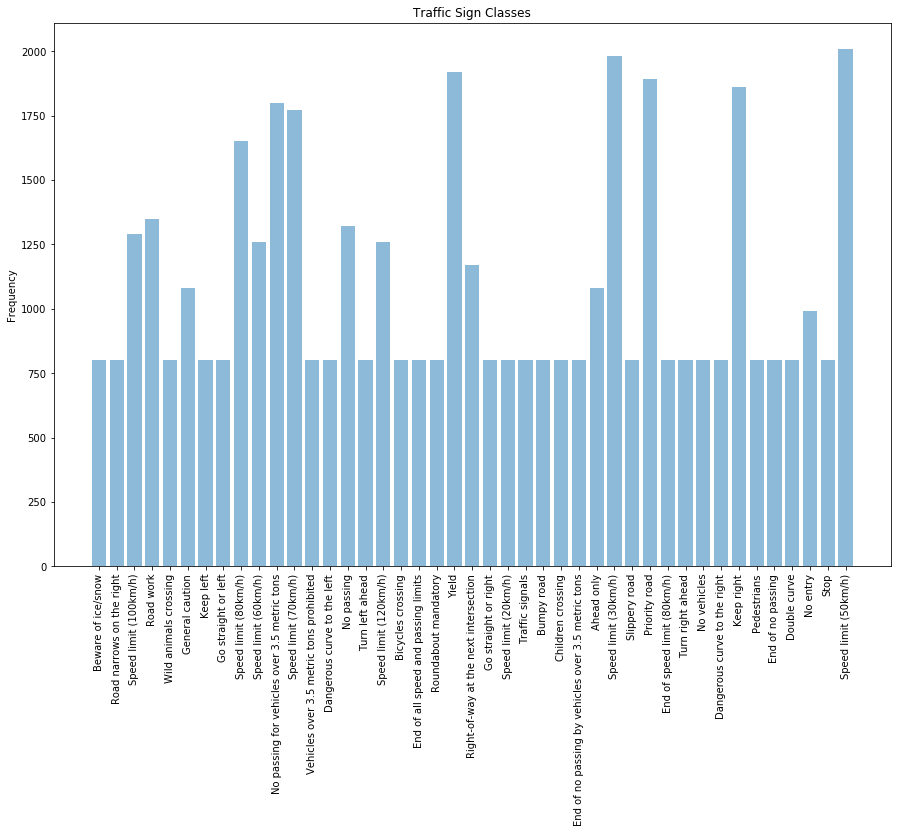

In [7]:
# Plot Frequency again
sign_frequencies = get_frequencies(y_train_augmented, sign_dict)

fig, ax = plt.subplots(figsize=(15, 10))
classes = list(sign_dict.values())
ind = np.arange(len(classes))
width = 0.8

rects = ax.bar(ind, sign_frequencies.values(), width, align="edge", alpha=0.5)
ax.set_ylabel('Frequency')
ax.set_title('Traffic Sign Classes')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(sign_frequencies.keys(), rotation=90)
plt.show()

[202, 25609, 5448, 8937, 6803, 41411, 3215, 26299, 16357]


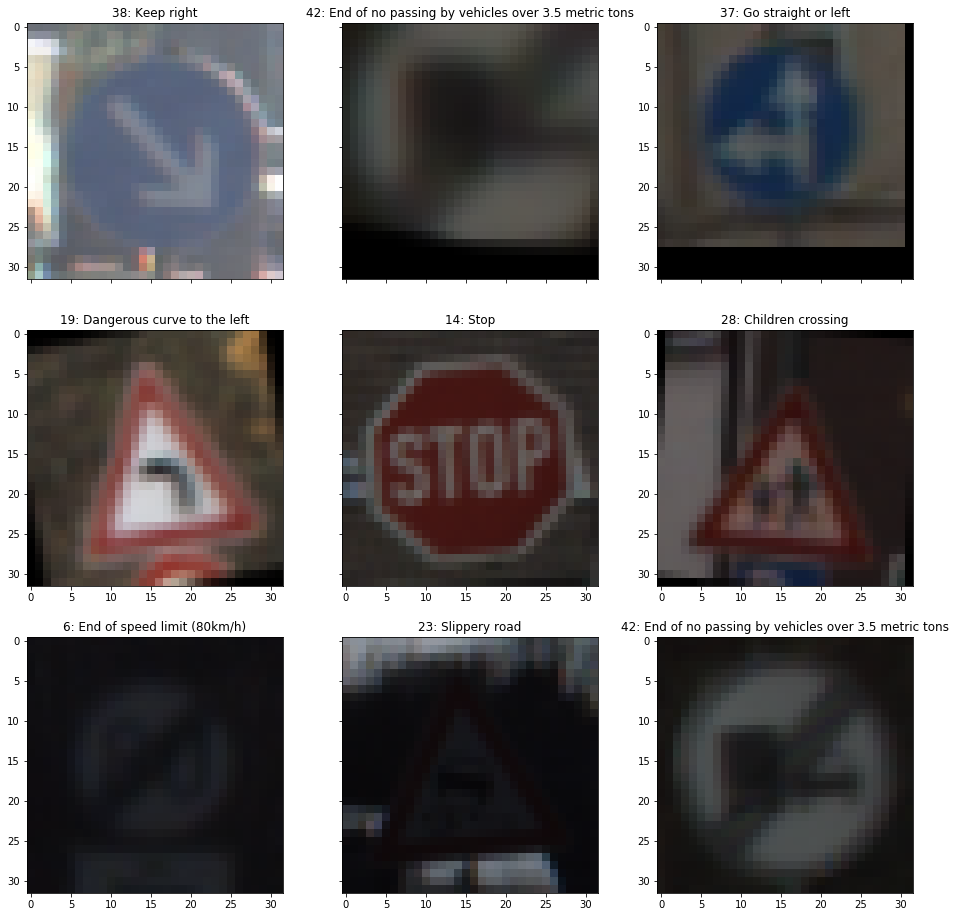

In [8]:
### Data exploration visualization code goes here.
X_train, y_train = shuffle(X_train_augmented, y_train_augmented)

def get_random_img(X_data, y_label):
    index = random.randint(0, len(X_data))
    image = X_data[index].squeeze()
    return image, y_label[index], index

def plot_imgs(X_data, y_label):
    f, axarr = plt.subplots(3, 3, figsize=(16, 16))
    rand_indices = []
    for i in range(9):
        image, label, index = get_random_img(X_data, y_label)
        rand_indices.append(index)
        label_str = str(label)
        axarr[i//3, i%3].imshow(image, cmap="gray")
        axarr[i//3, i%3].set_title(label_str+": "+sign_dict[label_str])
        # Fine-tune figure; hide x ticks for top plots and y ticks for right plots
        plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
        plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)
    return rand_indices
        
rand_img_indices = plot_imgs(X_train, y_train)
print(rand_img_indices)

In [9]:
index = rand_img_indices[7]
print(index)
print(X_train[index].shape)

26299
(32, 32, 3)


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

35836
[25784, 43957, 26463, 20625, 4484, 40526, 9850, 5836, 44317]


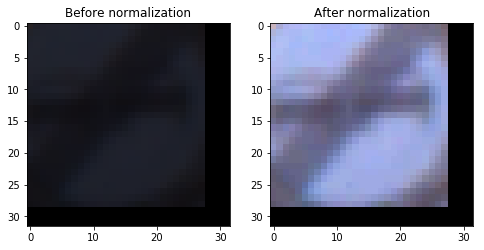

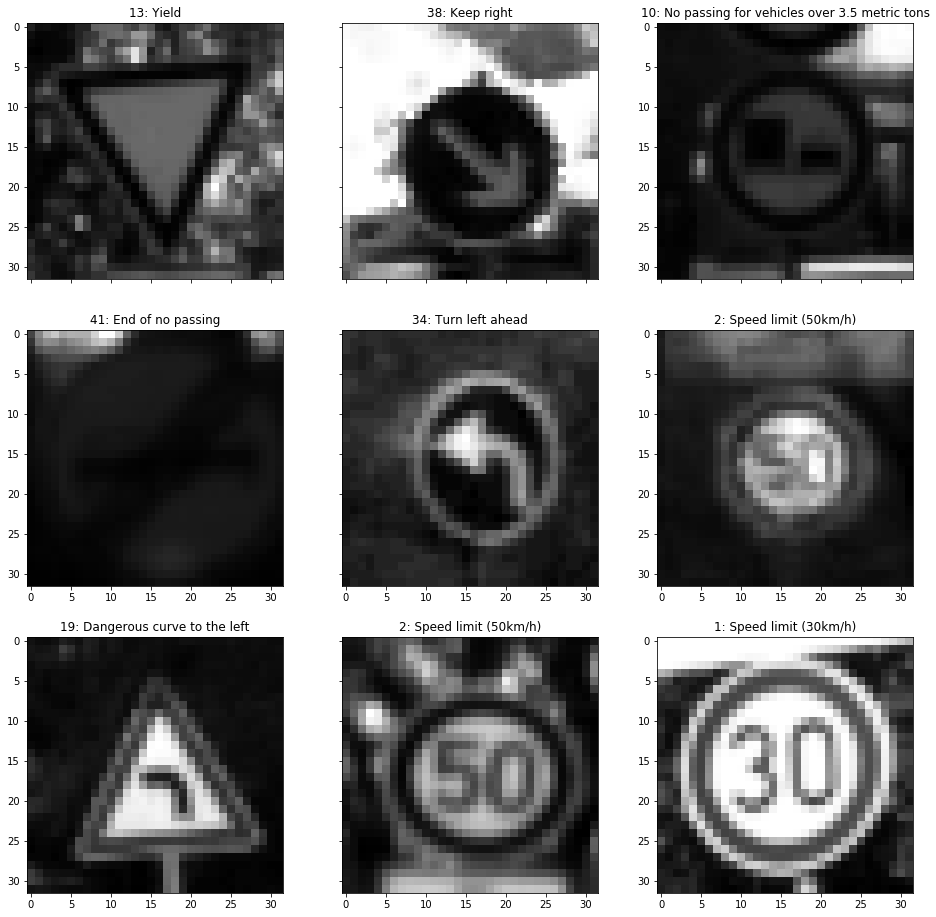

In [10]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.

def rgb2gray(rgb):
    gray_img = cv.cvtColor(rgb,cv.COLOR_BGR2GRAY)
    return np.asarray(gray_img)

# Normalization
def normalize(img):
    return cv.normalize(img, img, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)

# Find the darkest image in training data
img_sums = [sum(sum(rgb2gray(img))) for img in X_train]
min_ind = np.argmin(img_sums)
print(min_ind)

f, axarr = plt.subplots(1, 2, figsize=(8, 4))
axarr[0].imshow(X_train[min_ind], cmap="gray")
axarr[0].set_title('Before normalization')

normalized_gray = normalize(X_train[min_ind])
axarr[1].imshow(normalized_gray, cmap="gray")
axarr[1].set_title('After normalization')

# Normalize all training, validation data
# Gray all images
X_train = [rgb2gray(img) for img in X_train]
X_train = [normalize(img) for img in X_train]

rand_img_indices = plot_imgs(X_train, y_train)
print(rand_img_indices)

### Model Architecture

In [11]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

EPOCHS = 20
BATCH_SIZE = 150
rate = 0.002

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [12]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.

def LeNet6(x, n_classes):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    # MODIFIED: Layer 1: Convolutional. Input = 32x32x3 (rgb). Output = 28x28x6. shape (5,5,1,6)->(5,5,3,6)
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 252.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 252), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(252))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Dropout, to prevent overfitting
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 252. Output = 168.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(252, 168), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(168))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Dropout, to prevent overfitting
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # Layer 5: Fully Connected. Input = 168. Output = 84.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(168, 84), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(84))
    fc3    = tf.matmul(fc2, fc3_W) + fc3_b
    
    # Activation.
    fc3    = tf.nn.relu(fc3)
    
    # Dropout, to prevent overfitting
    fc3 = tf.nn.dropout(fc3, keep_prob)

    # Layer 6: Fully Connected. Input = 84. Output = n_classes, which is 43.
    fc4_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc4_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc3, fc4_W) + fc4_b
    
    return logits

In [13]:
### Model from Yann LeCun paper

def LeNetTrafficSign(x, n_classes):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    # MODIFIED: Layer 1: Convolutional. Input = 32x32x3 (rgb). Output = 28x28x6. shape (5,5,1,6)->(5,5,3,6)
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 3: Convolutional. Output = 1x1x400.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(400))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    
    # Activation.
    conv3 = tf.nn.relu(conv3)
    
    # Flatten. Input = 5x5x16. Output = 400.
    fc00   = flatten(conv2)
    # Flatten. Input = 1x1x400. Output = 400.
    fc01   = flatten(conv3)
    
    # Concatenate the two convs, Output = 800
    fc0 = tf.concat_v2([fc01, fc00], 1)
    
    fc0 = tf.nn.dropout(fc0, keep_prob)
    
    # Layer 4: Fully Connected. Input = 800. Output = 400.
    fc1_W  = tf.Variable(tf.truncated_normal(shape=(800, 400), mean = mu, stddev = sigma))
    fc1_b  = tf.Variable(tf.zeros(400))
    fc1    = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Dropout, to prevent overfitting
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # Layer 5: Fully Connected. Input = 400. Output = n_classes, which is 43.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(400, n_classes), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc1, fc2_W) + fc2_b
    
    return logits

## Features and Labels
Train LeNet to classify traffic sign data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

In [14]:
# Colored: (None, 32, 32, 3)
# Gray: (None, 32, 32, 1)
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

## Training Pipeline
Create a training pipeline that uses the model to classify traffic signdata.

In [15]:
logits = LeNetTrafficSign(x, n_classes)
print(logits)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Tensor("add_4:0", shape=(?, 43), dtype=float32)


## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

In [16]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    # Gray all images (optional)
#     X_data = [rgb2gray(img) for img in X_data]
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        batch_x = np.expand_dims(batch_x, axis=3)
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

Create training, validation split by using `StratifiedShuffleSplit`. For a split, the validation set is 1% of the training set, the percentage of the classes in the validation set is approximately the same as the original training set.

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

def nparray_to_list(nparray):
    return [x for x in nparray]

# Make sure the input and output formats are the same for X and y
def cv_split(X, y):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.05)
    X_np = np.asarray(X)
    y_np = np.asarray(y)
    for train_index, valid_index in sss.split(X_np, y_np):
        X_train, X_valid = nparray_to_list(X_np[train_index]), nparray_to_list(X_np[valid_index])
        y_train, y_valid = nparray_to_list(y_np[train_index]), nparray_to_list(y_np[valid_index])
    train = X_train, y_train
    valid = X_valid, y_valid
    return train, valid

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

In [18]:
for i in range(10):
    X_train, y_train = shuffle(X_train, y_train)
train, valid = cv_split(X_train, y_train)
X_train, y_train = train
X_valid, y_valid = valid

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    print("Number of examples: ", num_examples)
    print("Training...")
    for i in range(EPOCHS):
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            # Expand (128, 32, 32) to (128, 32, 32, 1)
            batch_x = np.expand_dims(batch_x, axis=3)
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Number of examples:  44156
Training...
EPOCH 1 ...
Training Accuracy = 0.890
Validation Accuracy = 0.877

EPOCH 2 ...
Training Accuracy = 0.940
Validation Accuracy = 0.926

EPOCH 3 ...
Training Accuracy = 0.957
Validation Accuracy = 0.944

EPOCH 4 ...
Training Accuracy = 0.973
Validation Accuracy = 0.960

EPOCH 5 ...
Training Accuracy = 0.977
Validation Accuracy = 0.962

EPOCH 6 ...
Training Accuracy = 0.984
Validation Accuracy = 0.966

EPOCH 7 ...
Training Accuracy = 0.989
Validation Accuracy = 0.973

EPOCH 8 ...
Training Accuracy = 0.992
Validation Accuracy = 0.977

EPOCH 9 ...
Training Accuracy = 0.994
Validation Accuracy = 0.977

EPOCH 10 ...
Training Accuracy = 0.994
Validation Accuracy = 0.979

EPOCH 11 ...
Training Accuracy = 0.995
Validation Accuracy = 0.981

EPOCH 12 ...
Training Accuracy = 0.996
Validation Accuracy = 0.977

EPOCH 13 ...
Training Accuracy = 0.996
Validation Accuracy = 0.981

EPOCH 14 ...
Training Accuracy = 0.997
Validation Accuracy = 0.978

EPOCH 15 ...
Train

## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

In [19]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    X_test = [normalize(rgb2gray(img)) for img in X_test]
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.942


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

(6, 32, 32, 3)


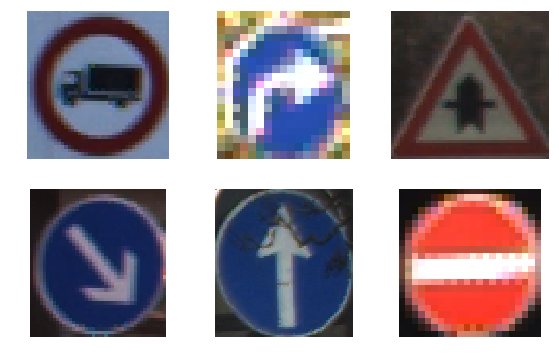

In [20]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import glob
import matplotlib.image as mpimg
import csv
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import random
from sklearn.utils import shuffle
import tensorflow as tf

fig, axs = plt.subplots(2,3, figsize=(10, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

my_images = []

for i, img in enumerate(glob.glob('./my-signs/*.png')):
    image = cv.imread(img)
    axs[i].axis('off')
    axs[i].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    image = cv.resize(image, (32,32))
    my_images.append(image)

my_images = np.asarray(my_images)
print(my_images.shape)

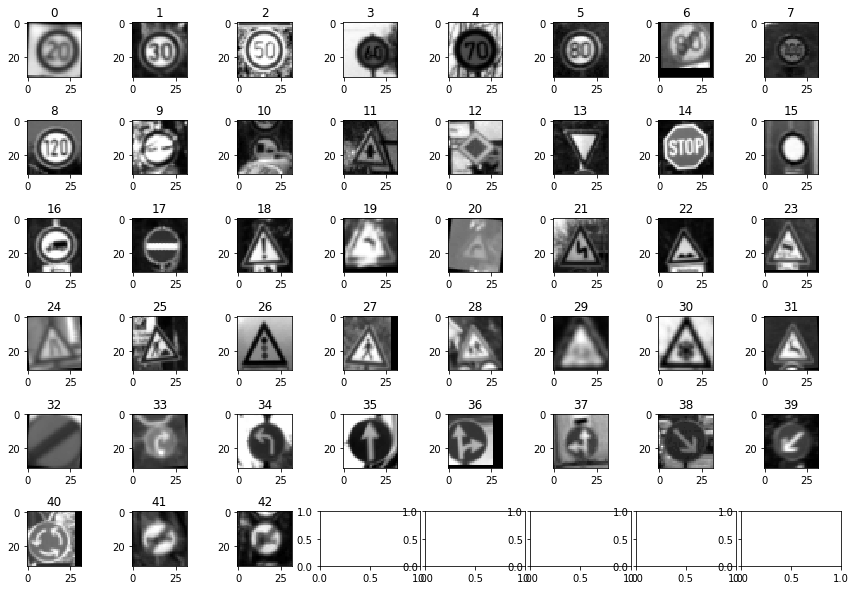

In [21]:
show_class_images()

### Predict the Sign Type for Each Image

In [22]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
my_labels = [16, 33, 11, 38, 35, 17]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    my_images_normalized = [normalize(rgb2gray(img)) for img in my_images]
    my_accuracy = evaluate(my_images_normalized, my_labels)
    print("Test Set Accuracy = {:.3f}".format(my_accuracy))

Test Set Accuracy = 1.000


### Analyze Performance

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

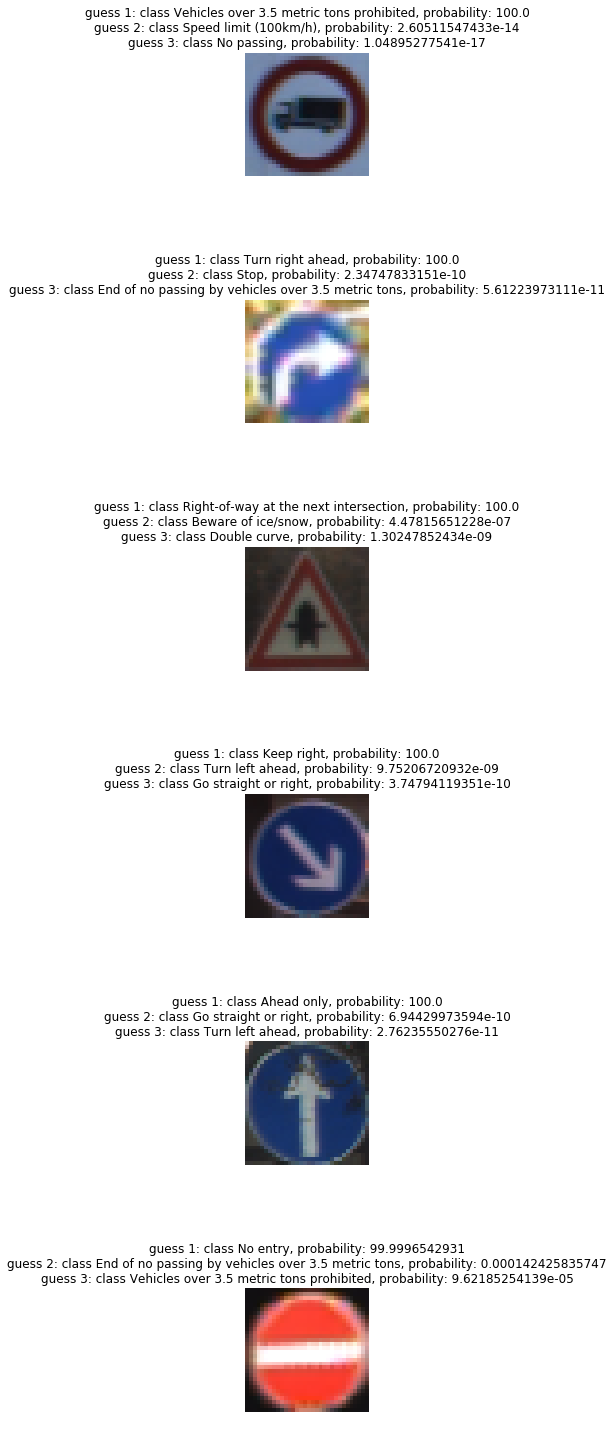

In [23]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=3)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    batch_x = np.expand_dims(my_images_normalized, axis=3)
    sample_softmax_logits = sess.run(softmax_logits, feed_dict={x: batch_x, keep_prob: 1.0})
    my_top_k = sess.run(top_k, feed_dict={x: batch_x, keep_prob: 1.0})
    
    fig, axs = plt.subplots(len(my_images),1, figsize=(20, 25))
    fig.subplots_adjust(hspace = 1.0, wspace=.6)
    axs = axs.ravel()

    for i, image in enumerate(my_images):
        axs[i].axis('off')
        axs[i].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
        guess1 = my_top_k[1][i][0]
        index1 = np.argwhere(y_valid == guess1)[0]

        guess2 = my_top_k[1][i][1]
        index2 = np.argwhere(y_valid == guess2)[0]
        
        guess3 = my_top_k[1][i][2]
        index3 = np.argwhere(y_valid == guess3)[0]
        title = ""
        title += "guess 1: class " + sign_dict[str(guess1)] + ", probability: " + str(100*my_top_k[0][i][0]) + "\n"
        title += "guess 2: class " + sign_dict[str(guess2)] + ", probability: " + str(100*my_top_k[0][i][1]) + "\n"
        title += "guess 3: class " + sign_dict[str(guess3)] + ", probability: " + str(100*my_top_k[0][i][2])
        axs[i].set_title(title)

In [24]:
print(sign_dict['16'])
print(sign_dict['33'])
print(sign_dict['11'])
print(sign_dict['38'])
print(sign_dict['35'])
print(sign_dict['17'])

Vehicles over 3.5 metric tons prohibited
Turn right ahead
Right-of-way at the next intersection
Keep right
Ahead only
No entry
